# Importar librerías

In [18]:
import pandas as pd
import pandas_profiling
from datetime import datetime
import os
import numpy as np
import seaborn as sns
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import sys
sys.setrecursionlimit(5000)

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

def set_seed(seed=42):
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
set_seed()

pd.set_option("display.width", 100)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 20)

print("setup-complete!")

setup-complete!


# Funciones

In [19]:
def missing_zero_values_table(df):
    """
    Obtener tabla resumen de valores ceros y faltantes en cada columna
    
    Parámetros
    ----------
    df : DataFrame
        
    Regresa
    -------
    mz_table : Dataframe
        Regresa la tabla resumen con valores faltantes y ceros
    """
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mz_table = pd.concat([zero_val, mis_val], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Valores Cero', 1 : 'Valores missing'})
    mz_table['Valores cero y missing'] = mz_table['Valores Cero'] + mz_table['Valores missing']
    mz_table['% de cero y missing'] = 100 * mz_table['Valores cero y missing'] / len(df)
    mz_table['Tipo de dato'] = df.dtypes
    mz_table = mz_table.sort_values(
    '% de cero y missing', ascending=False).round(3)
    print ("El dataframe seleccionado tiene " + str(df.shape[1]) + " columnas y " + str(df.shape[0]) + " filas.\n"      
        "Hay " + str(mz_table.shape[0]) +
            " columnas que no tienen valores vacíos.")
    return mz_table

In [20]:
def univariate_analysis(data, color, title1, title2):
    
    """
    Mostrando visualización de análisis univariado
    con displot y qqplot, visualización 
    de seaborn y statsmodel
    
    Parámetros
    ----------
    data : DataFrame o array
        Dataset para plotear. 
    title1: Titulo para displot
    title2: Titulo para quantilplit
        
    Regresa
    -------
    fig : matplotlib figure
        Regrse una figura con los dos gráficos
    """
    
    fig, (ax1, ax2) = plt.subplots(
        ncols=2,
        nrows=1,
        figsize=(20, 6)
    )

    sns.distplot( 
        data,
        ax=ax1,
        kde=True,
        color=color 
    )
    
    ax1.set_title(
        title1, 
        weight="bold",
        fontname="monospace", 
        fontsize=25, 
        pad=30 
    )
    
    qqplot( 
        data, 
        ax=ax2, 
        line='s' 
    )
    
    ax2.set_title( 
        title2, 
        weight="bold", 
        fontname="monospace", 
        fontsize=25, 
        pad=30 
    )
    
    return fig 

# Leer Dataset

In [21]:
df=pd.read_csv('../data/in/datos_de_prueba.csv')
df.head()

,ID del cliente,Sexo,Edad,Ingresos,Tipo de hogar,Estado civil,Número de hijos,Puntuación de crédito,Tipo de trabajo,Educación,Fecha de inicio de la póliza,Tipo de seguro,Monto del seguro,Fecha del reclamo,Monto del reclamo
0,1,Femenino,28,558900,Departamento,Viudo,3,556,Empresario,Preparatoria,2022-03-28,Vida,1806,2022-11-14,558
1,2,Femenino,18,212925,Departamento,Viudo,1,330,Empleado,Posgrado,2022-09-15,Vida,1371,2022-04-25,922
2,3,Femenino,37,838328,Departamento,Casado,3,776,Empresario,Universidad,2022-03-18,Hogar,6751,2022-07-31,3128
3,4,Masculino,25,459616,Casa,Soltero,4,821,Independiente,Universidad,2022-11-14,Hogar,5448,2022-07-29,1493
4,5,Masculino,41,678250,Casa,Casado,4,580,Empresario,Universidad,2023-03-02,Vida,5625,2022-07-08,1907


# EDA

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ID del cliente                3000 non-null   int64 
 1   Sexo                          3000 non-null   object
 2   Edad                          3000 non-null   int64 
 3   Ingresos                      3000 non-null   int64 
 4   Tipo de hogar                 3000 non-null   object
 5   Estado civil                  3000 non-null   object
 6   Número de hijos               3000 non-null   int64 
 7   Puntuación de crédito         3000 non-null   int64 
 8   Tipo de trabajo               3000 non-null   object
 9   Educación                     3000 non-null   object
 10  Fecha de inicio de la póliza  3000 non-null   object
 11  Tipo de seguro                3000 non-null   object
 12  Monto del seguro              3000 non-null   int64 
 13  Fecha del reclamo 

Tenemos 7 columnas de tipo entero y 8 de tipo objeto

In [23]:
missing_zero_values_table(df)

El dataframe seleccionado tiene 15 columnas y 3000 filas.
Hay 15 columnas que no tienen valores vacíos.


,Valores Cero,Valores missing,Valores cero y missing,% de cero y missing,Tipo de dato
Número de hijos,489,0,489,16.300,int64
Monto del reclamo,1,0,1,0.033,int64
ID del cliente,0,0,0,0.000,int64
Sexo,0,0,0,0.000,object
Edad,0,0,0,0.000,int64
Ingresos,0,0,0,0.000,int64
Tipo de hogar,0,0,0,0.000,object
Estado civil,0,0,0,0.000,object
Puntuación de crédito,0,0,0,0.000,int64
Tipo de trabajo,0,0,0,0.000,object


* Se observa que hay solo 2 variables que contienen valores 0 y corresponde menos del 17% de la variable
* No se observa valores nulos

## Validación de duplicados

In [24]:
df['ID del cliente'].nunique()==df.shape[0]

True

No hay duplicados de clientes

## Transformaciones

Se convierte la variable "Fecha de inicio de la póliza"" en formato fecha para obtener componentes temporales e incluirlos dentro del modelo. Aplica lo mismo para "Fecha del reclamo" pero no se meterá al modelo pues es una variable parte del target

In [25]:
df['start_date'] = pd.to_datetime(df['Fecha de inicio de la póliza'])
df['claim_date'] = pd.to_datetime(df['Fecha del reclamo'])

df['start_date_day'] = df['start_date'].dt.day
df['start_date_month'] = df['start_date'].dt.month
df['start_date_weekday'] = df['start_date'].dt.weekday

df['diff_claim_start']=(df['claim_date'] - df['start_date']) / np.timedelta64(1, 'D')

## Analisis univariado

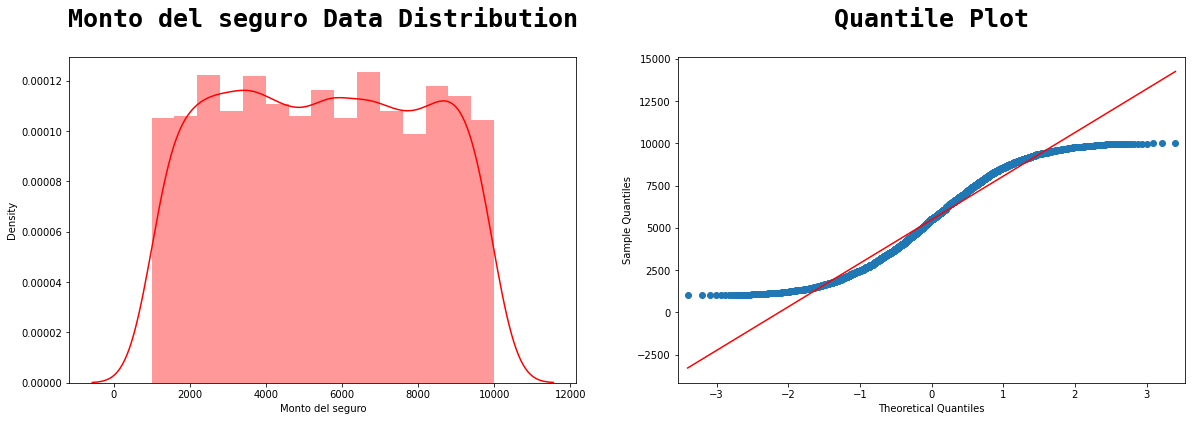

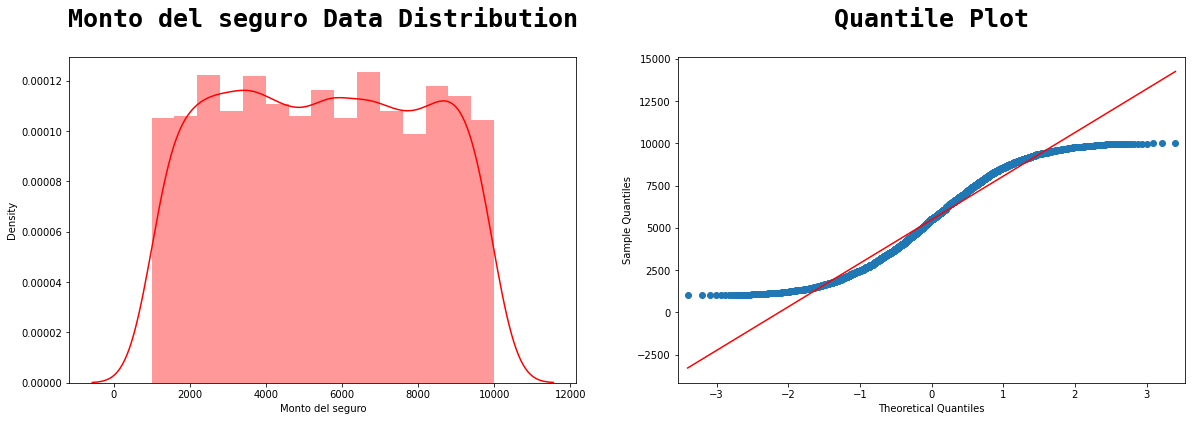

In [29]:
univariate_analysis( 
    data=df["Monto del seguro"], 
    color="red", 
    title1="Monto del seguro Data Distribution", 
    title2="Quantile Plot")

El histograma es simétrico y no sigue una distribución normal por el gráfico de la derecha (No fitea en la recta del Q-Q plot)- Sigue una distribución **uniforme**

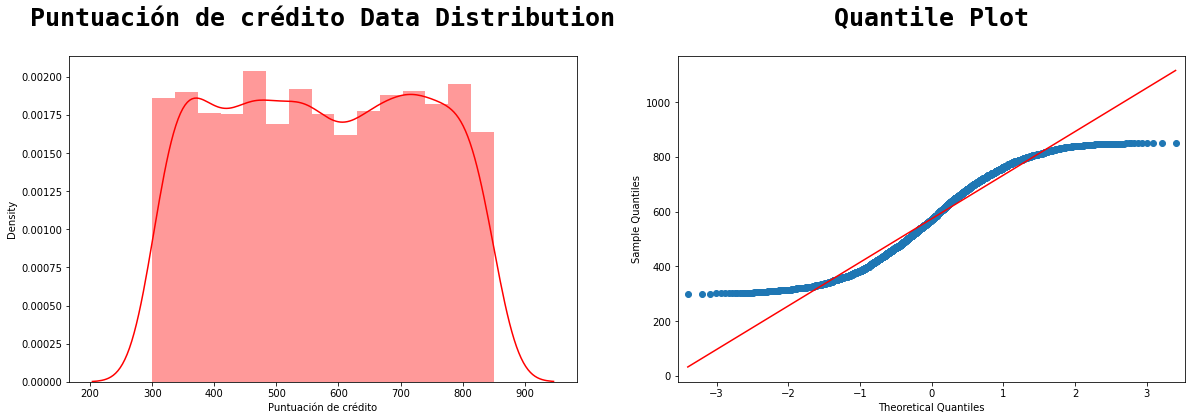

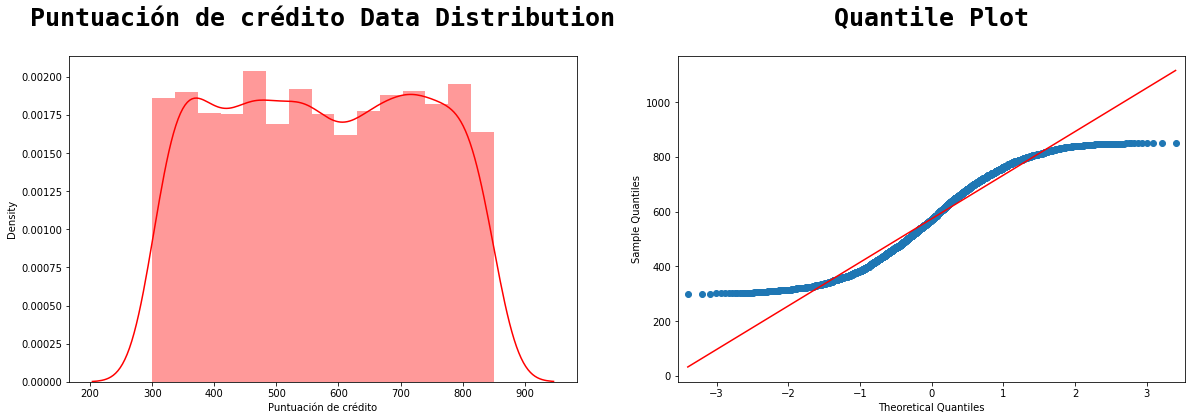

In [30]:
univariate_analysis( 
    data=df["Puntuación de crédito"], 
    color="red", 
    title1="Puntuación de crédito Data Distribution",
    title2="Quantile Plot")

El histograma es simétrico y no sigue una distribución normal por el gráfico de la derecha (No fitea en la recta del Q-Q plot)- Sigue una distribución **uniforme**

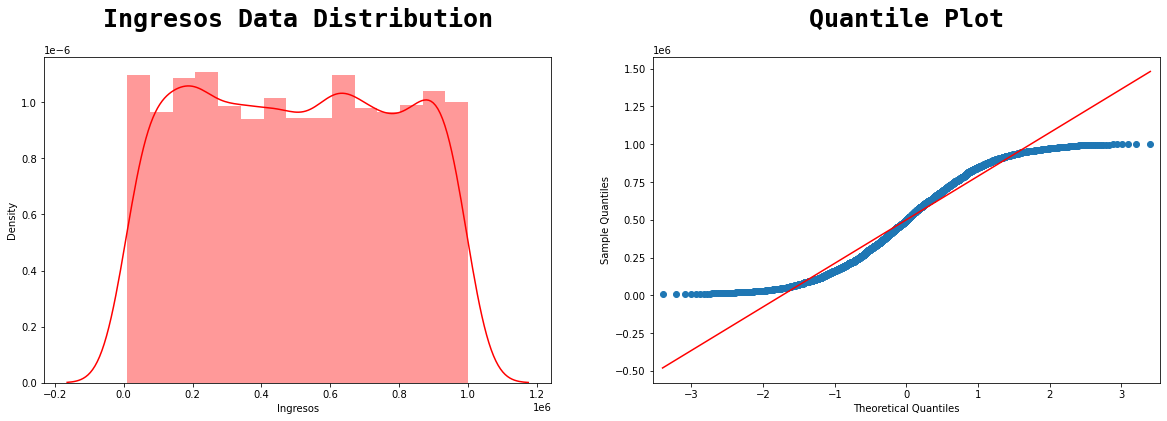

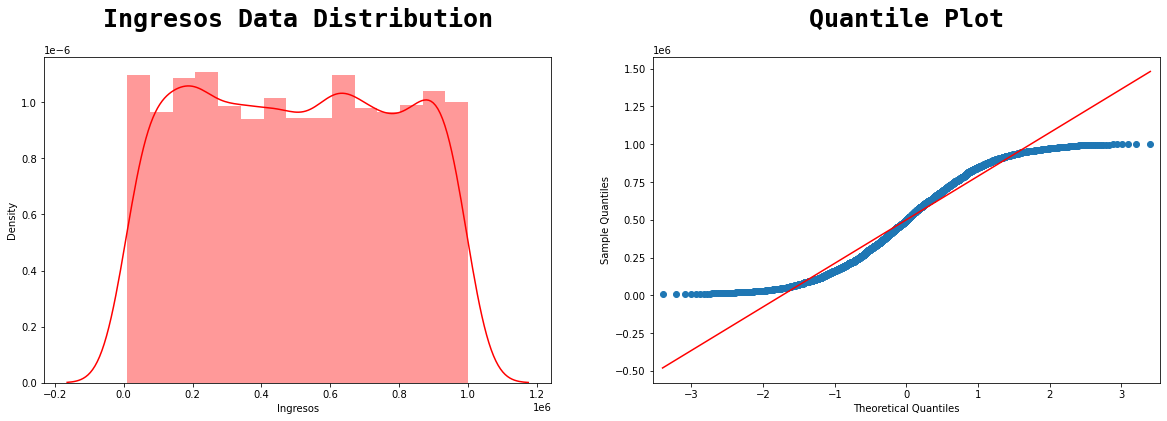

In [31]:
univariate_analysis( 
    data=df["Ingresos"], 
    color="red", 
    title1="Ingresos Data Distribution",
    title2="Quantile Plot")

El histograma es simétrico y no sigue una distribución normal por el gráfico de la derecha (No fitea en la recta del Q-Q plot)- Sigue una distribución **uniforme**

## Diseño del target

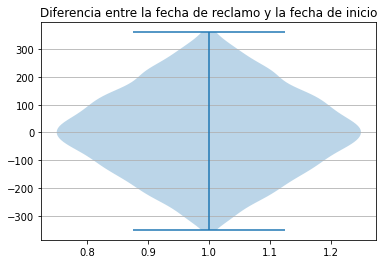

In [32]:
fig, axes = plt.subplots()

axes.violinplot(dataset = [df["diff_claim_start"].values] )

axes.set_title('Diferencia entre la fecha de reclamo y la fecha de inicio')
axes.yaxis.grid(True)

plt.show()

la diferencia entre fecha de reclamo y fecha de inicio de póliza es una normal

In [33]:
print('Diferencia maxima entre reclamo e inicio',df["diff_claim_start"].max())
print('Q de reclamos con una diferencia de min 360 dias',df[df['diff_claim_start']>=360].shape[0])

Diferencia maxima entre reclamo e inicio 361.0
Q de reclamos con una diferencia de min 360 dias 1


In [34]:
df[df["claim_date"]>='2023-01-01'].shape

(530, 21)

Entonces el target del modelo se define como 1 a aquellos clientes que hicieron un reclamo en 2023 y su fecha de póliza inicio en 2022

In [36]:
df['target']=np.where(df["claim_date"].dt.year>df["start_date"].dt.year,1,0)

Ya que el hecho de hacer un reclamo esta correlacionado al target e implica ya lo que buscamos predecir eliminamos esas variables relacionadas al reclamo. También se elimina la variable "ID del cliente" porque no es una variable explicativa

In [37]:
df.drop(columns=['claim_date','diff_claim_start',
                 'Monto del reclamo','Fecha del reclamo','Fecha de inicio de la póliza'],inplace=True)

## Generación de reporte de pandas profilling

El siguiente reporte que se genera, nos brinda un overview de cada variable y su dsitribución ya se variable categórica, fecha o numérica. Al mismo tiempo, se puede visualizar las interacciones con la variable objetivo que es trip duration. Por último, se observa un gráfico de correlación para determinar la relación entre las variables.

In [40]:
profile=df.drop(columns=['ID del cliente','start_date']).profile_report(
    title='Data Profile',
    correlations={'spearman':{'calculate':True},
                 'pearson':{'calculate':True}},
    interactions={'targets':['target'],'continuous':True},
)

In [41]:
profile.to_file('df_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

En este reporte se observa que casi todas las variables categóricas tienen sus clases casi igualmente distribuidas

# Data Preprocessing

Las variables categóricas son tratadas con <code>get_dummies</code> para crear nuevas columnas y estas se activen si la fila presenta el valor del nombre de la columna

In [42]:
df=pd.get_dummies(df,prefix=['Sexo',
                             'Tipo de hogar',
                             'Estado civil',
                             'Tipo de trabajo',
                             'Educación',
                             'Tipo de seguro'],
                    columns = ['Sexo',
                               'Tipo de hogar',
                               'Estado civil',
                               'Tipo de trabajo',
                               'Educación',
                               'Tipo de seguro'], drop_first=True)

In [43]:
df.head()

,ID del cliente,Edad,Ingresos,Número de hijos,Puntuación de crédito,Monto del seguro,start_date,start_date_day,start_date_month,start_date_weekday,target,Sexo_Masculino,Tipo de hogar_Departamento,Estado civil_Divorciado,Estado civil_Soltero,Estado civil_Viudo,Tipo de trabajo_Empresario,Tipo de trabajo_Independiente,Educación_Preparatoria,Educación_Universidad,Tipo de seguro_Hogar,Tipo de seguro_Salud,Tipo de seguro_Vida
0,1,28,558900,3,556,1806,2022-03-28,28,3,0,0,0,1,0,0,1,1,0,1,0,0,0,1
1,2,18,212925,1,330,1371,2022-09-15,15,9,3,0,0,1,0,0,1,0,0,0,0,0,0,1
2,3,37,838328,3,776,6751,2022-03-18,18,3,4,0,0,1,0,0,0,1,0,0,1,1,0,0
3,4,25,459616,4,821,5448,2022-11-14,14,11,0,0,1,0,0,1,0,0,1,0,1,1,0,0
4,5,41,678250,4,580,5625,2023-03-02,2,3,3,0,1,0,0,0,0,1,0,0,1,0,0,1


La variable X contendrá todas las variables menos la variable target y la variable start_date
<br><br>

Mientras que la variable y, para este ejercicio se toma la variable target

In [44]:
X = df.drop(columns=['ID del cliente','start_date','target'])
y = df['target']

In [45]:
df.to_csv('../data/out/data_proc.csv',index=False)

Se estandariza las variables independientes para que estén a la misma escala

In [46]:
cols = X.columns

ss = StandardScaler()

new_df = ss.fit_transform(X)
new_df = pd.DataFrame(new_df, columns=cols)
new_df.head()

,Edad,Ingresos,Número de hijos,Puntuación de crédito,Monto del seguro,start_date_day,start_date_month,start_date_weekday,Sexo_Masculino,Tipo de hogar_Departamento,Estado civil_Divorciado,Estado civil_Soltero,Estado civil_Viudo,Tipo de trabajo_Empresario,Tipo de trabajo_Independiente,Educación_Preparatoria,Educación_Universidad,Tipo de seguro_Hogar,Tipo de seguro_Salud,Tipo de seguro_Vida
0,-1.142275,0.203675,0.297676,-0.111296,-1.426152,1.400569,-1.004979,-1.505939,-1.001334,1.004678,-0.568625,-0.565545,1.682682,1.407873,-0.696526,1.393261,-0.667148,-0.576837,-0.579916,1.685595
1,-1.690436,-0.996147,-0.883577,-1.530712,-1.594900,-0.072521,0.729571,-0.009973,-1.001334,1.004678,-0.568625,-0.565545,1.682682,-0.710291,-0.696526,-0.717741,-0.667148,-0.576837,-0.579916,1.685595
2,-0.648931,1.172716,0.297676,1.270436,0.492137,0.267422,-1.004979,0.488682,-1.001334,1.004678,-0.568625,-0.565545,-0.594289,1.407873,-0.696526,-0.717741,1.498917,1.733592,-0.579916,-0.593262
3,-1.306723,-0.140636,0.888302,1.553063,-0.013329,-0.185836,1.307755,-1.505939,0.998668,-0.995344,-0.568625,1.768205,-0.594289,-0.710291,1.435697,-0.717741,1.498917,1.733592,-0.579916,-0.593262
4,-0.429667,0.617574,0.888302,0.039438,0.055334,-1.545611,-1.004979,-0.009973,0.998668,-0.995344,-0.568625,-0.565545,-0.594289,1.407873,-0.696526,-0.717741,1.498917,-0.576837,-0.579916,1.685595


Se divide en train y test para realizar validaciones

In [47]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=0.30, random_state=0,stratify=y)

# Feature Selection

<code>f_regression</code> permite derteminar si una variable independiente es significativa para la variable dependiente y rankea de acuerdo F-value

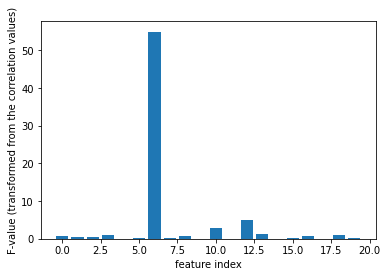

In [48]:

f_selector = SelectKBest(score_func=f_regression, k='all')

f_selector.fit(X_train, y_train)

X_train_fs = f_selector.transform(X_train)

X_test_fs = f_selector.transform(X_test)

plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("F-value (transformed from the correlation values)")
plt.show()

Se observa que las variables en el índice 6 tienen mayor relación

Así como el método anterior, <code>mutual_info_regression</code> permite verificar si existe una relación de dependencia entre dos variables: en este caso con la variable y. Esta función tiene como base un método no paramétrico.

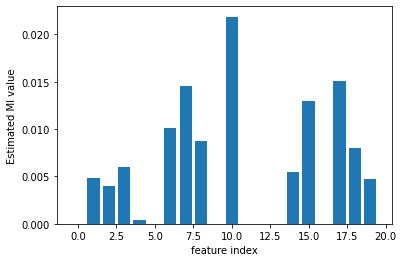

In [49]:

f_selector = SelectKBest(score_func=mutual_info_regression, k='all')

f_selector.fit(X_train, y_train)

X_train_fs = f_selector.transform(X_train)

X_test_fs = f_selector.transform(X_test)

plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("Estimated MI value")
plt.show()

Se observa que las variables en el índice 10 y 17 tienen mayor relación

Se utiliza el método de OLS (Mínimos cuadrados ordinarios) para validar si existe una relación de dependencia entre las variables independientes y dependiente.

In [50]:

X_1 = sm.add_constant(X_train)

model = sm.OLS(y_train,X_1).fit()
model.pvalues

const                     1.662455e-76
Edad                      3.250423e-01
Ingresos                  2.431255e-01
Número de hijos           4.917663e-01
Puntuación de crédito     3.156258e-01
                              ...     
Educación_Preparatoria    3.888322e-01
Educación_Universidad     1.513458e-01
Tipo de seguro_Hogar      3.339405e-01
Tipo de seguro_Salud      1.782858e-01
Tipo de seguro_Vida       4.009270e-01
Length: 21, dtype: float64

Según este análisis lineal, casi todas las variables no tienen un pvalue menor a 0.05 por lo que NO son significativas para el modelo

Por útlimo, probamos el con método de **backward elimination** que busca eliminar las variables que menos aportan a explicar la variable dependiente 

In [51]:

cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['start_date_month', 'Estado civil_Viudo']


Se llega a eliminar todas las variables con el método de OLS excepto "start_date_month" y "Estado civil_Viudo"

# Entrenamiento de modelos

Utilizaremos las siguientes métricas para comparar los modelos:
* AUC

## Logistic regression

In [52]:
model=LogisticRegression()
model.fit(X_train,y_train)
pred=model.predict_proba(X_test)[:,1]

In [53]:
#examining scores

print ("Training Score : " , roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))

print ("Validation Score : ", roc_auc_score(y_test,pred))

print ("Cross Validation Score : " , cross_val_score(model, X_train, y_train,scoring="roc_auc", cv=5).mean())

Training Score :  0.6478870439937913
Validation Score :  0.5619870580808081
Cross Validation Score :  0.5964934229953334


## Árbol de decisión

In [54]:
from sklearn.tree import DecisionTreeClassifier

est_dt = DecisionTreeClassifier(max_depth=10)
est_dt.fit(X_train, y_train)
dt_pred = est_dt.predict_proba(X_test)[:,1]

In [55]:
#examining scores

print ("Training Score : " , roc_auc_score(y_train,est_dt.predict_proba(X_train)[:,1]))

print ("Validation Score : ", roc_auc_score(y_test,dt_pred))

print ("Cross Validation Score : " , cross_val_score(est_dt, X_train, y_train,scoring="roc_auc", cv=5).mean())

Training Score :  0.8955953807151542
Validation Score :  0.490954466540404
Cross Validation Score :  0.5934902107268439


## Bosque aleatorio

In [56]:
from sklearn.ensemble import RandomForestClassifier

est_rf = RandomForestClassifier(n_estimators=50, max_depth=10)
est_rf.fit(X_train, y_train)
rf_pred = est_rf.predict(X_test)

In [57]:
#examining scores

print ("Training Score : " , roc_auc_score(y_train,est_rf.predict_proba(X_train)[:,1]))

print ("Validation Score : ", roc_auc_score(y_test,rf_pred))

print ("Cross Validation Score : " , cross_val_score(est_rf, X_train, y_train,scoring="roc_auc", cv=5).mean())

Training Score :  0.9996458379636406
Validation Score :  0.5
Cross Validation Score :  0.5609406039626326


## Lightgbm Classifier

In [58]:
model = lgb.LGBMClassifier(boosting_type= 'gbdt',
    n_estimators= 50,random_state=1)
model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],verbose=False)
pred = model.predict_proba(X_test)[:,1] 

In [59]:
#examining scores

print ("Training Score : " , roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))

print ("Validation Score : ", roc_auc_score(y_test,pred))

print ("Cross Validation Score : " , cross_val_score(model, X_train, y_train,scoring="roc_auc", cv=5).mean())

Training Score :  0.9995048959287628
Validation Score :  0.555792297979798
Cross Validation Score :  0.5612054496555811


Estamos viendo que con esta muestra no se tiene resultados consistentes con estas variables. El modelo esta overfitteando porque en el training se tiene un auc alto y en el validation baja totalmente. Ahora el ranking de mejor AUC según el cross_validation es el sgte:
1. Regresión Logística
2. DecisionTree
3. Lightgbm
4. Random Forest